## Figure 6: Model performance

This notebook reproduces Figure 6, using code largely taken from `01-create_pu_classifier.ipynb` and `01b-cross_validation.ipynb`.

In [1]:
use_extracted_data = False

In [2]:
import os
import warnings
from string import ascii_uppercase

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulearn.bagging import BaggingPuClassifier
from sklearn.base import clone
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

from lib.check_files import (
    check_prepared_data,
)
from lib.pu import (
    BASE_MODELS,
    PU_PARAMS,
    downsample_unlabelled,
    get_xy,
)

# Suppress FutureWarning for some versions of Scikit-learn
%env PYTHONWARNINGS=ignore::FutureWarning
warnings.simplefilter("ignore", FutureWarning)

env: PYTHONWARNINGS=ignore::FutureWarning


In [3]:
# Random seed for reproducibility
random_seed = 1232

# Number of jobs used to train model
n_jobs = 8

rf_params = {
    "random_state": random_seed,
    "n_estimators": 50,
}
pu_params = {
    "n_jobs": n_jobs,
    "random_state": random_seed,
    **PU_PARAMS
}
svm_params = {
    "kernel": "rbf",
    "probability": True,
    "random_state": random_seed,
}

In [4]:
# Input/output files
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)

data_filename = os.path.join(data_dir, "training_data.csv")
output_dir = "figures"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir, exist_ok=True)
output_basename = os.path.join(output_dir, "Fig-06-model_performance")

### Load and process training data

In [5]:
data = pd.read_csv(data_filename)

# Restrict unlabelled training data to the Americas
data = data[data["region"].isin({"NAm", "SAm"})]
data_na = data[data["region"] == "NAm"]
data_sa = data[data["region"] == "SAm"]

data = downsample_unlabelled(data, random_state=random_seed)
data_na = downsample_unlabelled(data_na, random_state=random_seed)
data_sa = downsample_unlabelled(data_sa, random_state=random_seed)

print(data.groupby(["region", "label"]).size())

region  label     
NAm     negative       57
        positive      217
        unlabelled    181
SAm     negative      632
        positive      130
        unlabelled    166
dtype: int64


### Train models

In [6]:
# Scaling not necessary for RF, but kept for consistency
scaler = RobustScaler()

base_model = clone(BASE_MODELS["randomforest"])
base_model.set_params(**rf_params)
model_pu = BaggingPuClassifier(base_model, **pu_params)
model_pu = make_pipeline(clone(scaler), model_pu)

model_svm = SVC(**svm_params)
model_svm = make_pipeline(clone(scaler), model_svm)

In [7]:
models = {"PU": model_pu, "SVM": model_svm}
datasets = {"All": data, "NA": data_na, "SA": data_sa}

trained_models = {}
values = {}
predictions = {}
for dset_name, dset in datasets.items():
    train, test = train_test_split(
        dset,
        test_size=0.2,
        random_state=random_seed,
        shuffle=True,
        stratify=dset["label"],
    )
    for model_name, m in models.items():
        key = (model_name, dset_name)
        print(key)

        model = clone(m)
        if model_name == "PU":
            labels = {"positive", "unlabeled", "unlabelled"}
        else:
            labels = {"positive", "negative"}
        train_subset = train[train["label"].isin(labels)]
        test = test[test["label"].isin({"positive", "negative"})]
        x_train, y_train = get_xy(train_subset)
        x_test, y_test = get_xy(test)
        model.fit(x_train, y_train)

        values[key] = y_test
        trained_models[key] = model
        probs = model.predict_proba(x_test)[:, 1]
        predictions[key] = probs

('PU', 'All')


('SVM', 'All')
('PU', 'NA')
('SVM', 'NA')
('PU', 'SA')
('SVM', 'SA')


### Test and visualise model performance

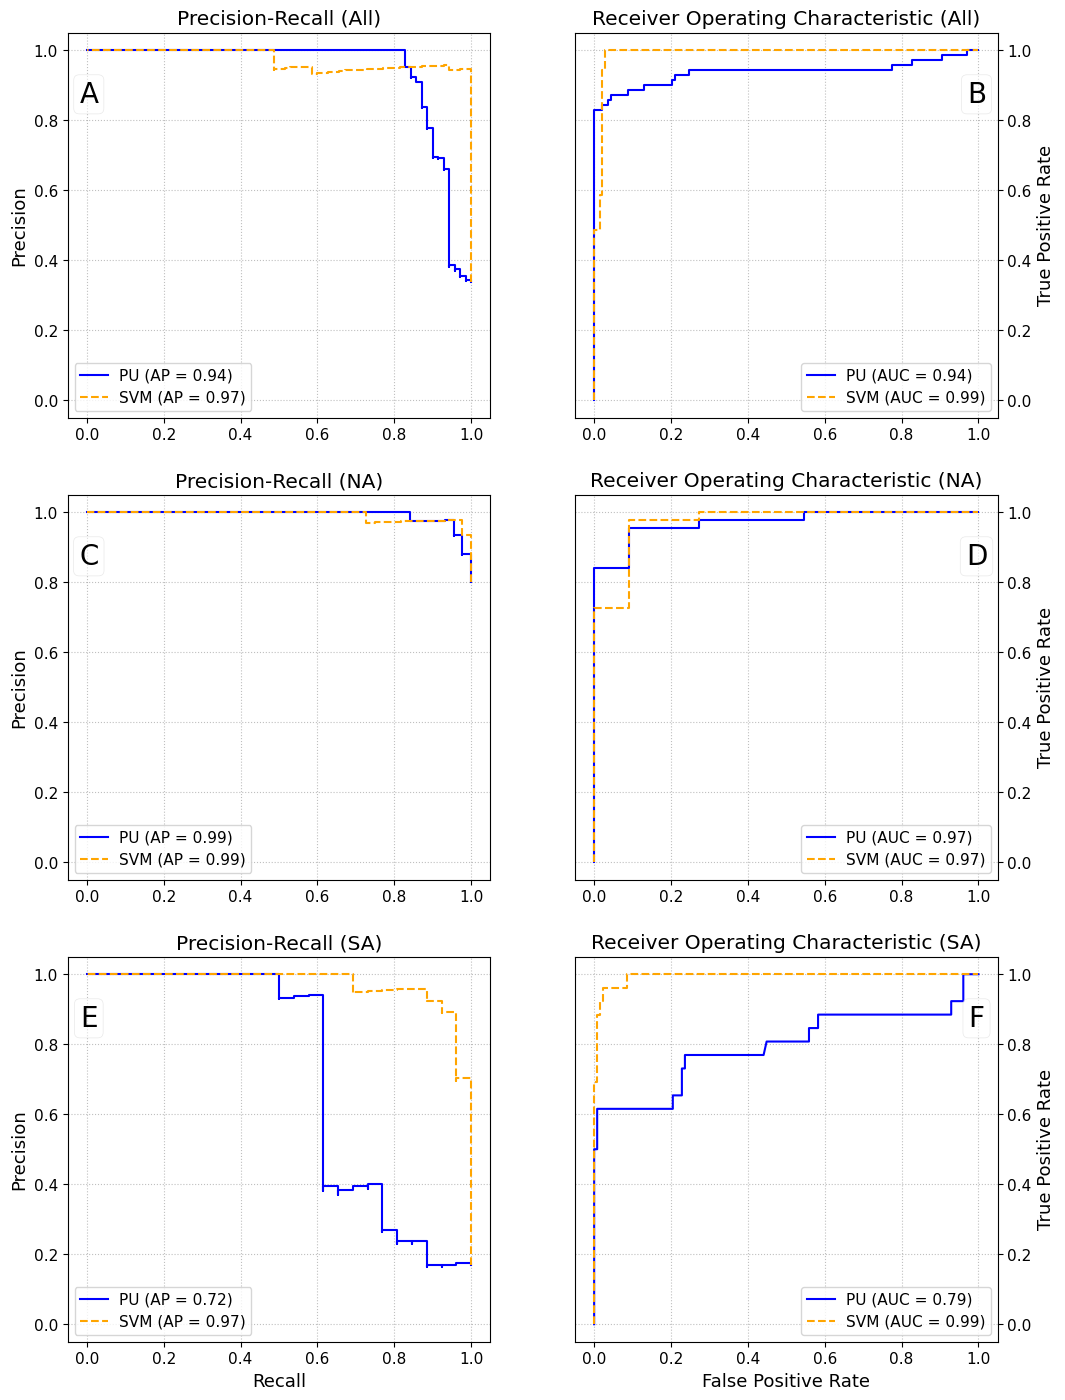

In [8]:
title_size = 14.5
caption_size = 20
label_size = 13
tick_size = 11

regions = ("All", "NA", "SA")
kwargs_dict = {
    "PU": {"color": "blue", "linestyle": "solid"},
    "SVM": {"color": "orange", "linestyle": "dashed"},
}
titles_dict = {
    PrecisionRecallDisplay: "Precision-Recall",
    RocCurveDisplay: "Receiver Operating Characteristic",
}

fig, axs = plt.subplots(3, 2, figsize=(12, 17))
for i, region in enumerate(regions):
    row = axs[i]
    for j, (ax, which) in enumerate(
        zip(
            row,
            (
                PrecisionRecallDisplay,
                RocCurveDisplay,
            ),
        )
    ):
        for model_name in ("PU", "SVM"):
            key = (model_name, region)
            v = values[key]
            p = predictions[key]

            which.from_predictions(
                v,
                p,
                name=model_name,
                ax=ax,
                **(kwargs_dict[model_name]),
            )
        ax.grid(
            linestyle="dotted",
            color="grey",
            alpha=0.5,
        )
        ax.set_title(
            f"{titles_dict[which]} ({region})",
            fontsize=title_size,
        )
        if i == 2:
            xlabel = ax.get_xlabel().replace(
                " (Positive label: 1)",
                "",
            )
        else:
            xlabel = ""
        ylabel = ax.get_ylabel().replace(
            " (Positive label: 1)",
            "",
        )
        if j == 0:
            label_x = 0.05
        else:
            # ylabel = ""
            label_x = 0.95
        ax.set_xlabel(xlabel, fontsize=label_size)
        ax.text(
            label_x,
            0.84,
            ascii_uppercase[(i * 2) + j],
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=caption_size,
            bbox=dict(
                facecolor="white",
                edgecolor="lightgrey",
                linewidth=0.5,
                boxstyle="Round, pad=0.2, rounding_size=0.2",
                alpha=0.5,
            )
        )
        left = j == 0
        right = not left
        ax.set_ylabel(ylabel, fontsize=label_size)
        if right:
            ax.yaxis.set_label_position("right")
        ax.tick_params(
            labelsize=tick_size,
            left=left,
            right=right,
            labelleft=left,
            labelright=right,
        )
        for t in ax.get_legend().get_texts():
            t.set_fontsize(tick_size)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlim(-0.05, 1.05)

for ext in (".png", ".pdf"):
    fig.savefig(output_basename + ext, dpi=350, bbox_inches="tight")